In [2463]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df1 = pd.read_csv('datasets/players.csv')
df2 = pd.read_csv('datasets/players_teams.csv')
df3 = pd.read_csv('datasets/awards_players.csv')
df4 = pd.read_csv('datasets/teams.csv')
df5 = pd.read_csv('datasets/teams_post.csv')
df6 = pd.read_csv('datasets/coaches.csv')
df7 = pd.read_csv('datasets/series_post.csv')

def corrige_vencedor(teams, series_post):
    # Itera sobre cada rodada ('F', 'CF', 'FR') para ajustar cada fase dos playoffs
    for round_type in ['FR', 'CF', 'F']:
        # Filtra a série específica da rodada
        series_round = series_post[series_post['round'] == round_type]
        
        # Atualiza cada série individualmente
        for _, row in series_round.iterrows():
            year = row['year']
            winner_id = row['tmIDWinner']
            loser_id = row['tmIDLoser']
            
            # Define as colunas que correspondem às rodadas
            if round_type == 'FR':
                round_column = 'firstRound'
            elif round_type == 'CF':
                round_column = 'semis'
            elif round_type == 'F':
                round_column = 'finals'
            
            # Marca o time vencedor como "W" na rodada correspondente
            teams.loc[(teams['year'] == year) & (teams['tmID'] == winner_id), round_column] = 'W'
            
            # Marca o time perdedor como "L" na rodada correspondente
            teams.loc[(teams['year'] == year) & (teams['tmID'] == loser_id), round_column] = 'L'
    
    return teams

teams_file = corrige_vencedor(df4, df7)

players_teams_file = df2.drop(columns=['lgID']) # tirar lgID de tudo porque é tudo igual

players_file = df1[df1['pos'].notna() & (df1['pos'] != '')] # tirar jogadoras com linhas vazias

players_file = players_file.drop(columns=['firstseason', 'lastseason', 'deathDate', 'collegeOther']) # dropar firstseason e lastseason porque têm os valores todos iguais, dropar deathDate porque quase ninguém morreu 
players_file['college'] = players_file['college'].apply(lambda x: 1 if pd.notnull(x) else 0) # substituir college por escolaridade

merged_df = pd.merge(players_teams_file, players_file, left_on='playerID', right_on='bioID', how='left') # merge players_teams e players

merged_df = merged_df.drop(columns=['bioID']) # tirar bioID porque já temos playerID
awards_players_file = df3.drop(columns=['lgID']) # tirar porque é tudo igual
teams_file = df4.drop(columns=['lgID', 'divID', 'tmORB','tmDRB','tmTRB','opptmORB','opptmDRB','opptmTRB','seeded']) # dropar lgID e divID porque é igual em tudo e o resto estava tudo a zero
teams_file['playoff'] = teams_file['playoff'].apply(lambda x: 1 if x=='Y' else 0) # substituir playoff por valores numericos

team_post_file = df5.drop(columns=['lgID']) # tirar lgID de tudo porque é tudo igual
series_post_file = df7.drop(columns=['lgIDWinner', 'lgIDLoser']) # tirar tudo porque é tudo igual
coaches_file = df6.drop(columns=['lgID']) # tirar lgID de tudo porque é tudo igual


awards_grouped = awards_players_file.groupby(['playerID', 'year'])['award'].apply(list).reset_index() # agrupamos numa lista todos os awards de cada jogadora em cada ano
awards_grouped['award'] = awards_grouped['award'].apply(lambda x: x if isinstance(x, list) else []) # se uma jogadora não tem awards -> lista vazia

merged_df = pd.merge(merged_df, awards_grouped, on=['playerID', 'year'], how='left') # merge do dataset que foi merged em cima com o dos awards
merged_df['award'] = merged_df['award'].apply(lambda x: x if isinstance(x, list) else []) # se uma jogadora não tem awards -> lista vazia
merged_df = pd.merge(merged_df, teams_file, on=['tmID','year'], how = 'left') # merge com o teams

merged_df = merged_df.drop(columns=['franchID', 'name']) # dropar franchID porque é igual à sigla da equipa e name porque já temos a sigla

merged_df = pd.merge(merged_df, team_post_file, on=['tmID','year'], how = 'left') # merge com o teams post

/tmp/ipykernel_136628/14480375.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  winner_summary = winner_counts.groupby(['year', 'round']).size().reset_index(name='winner_count')


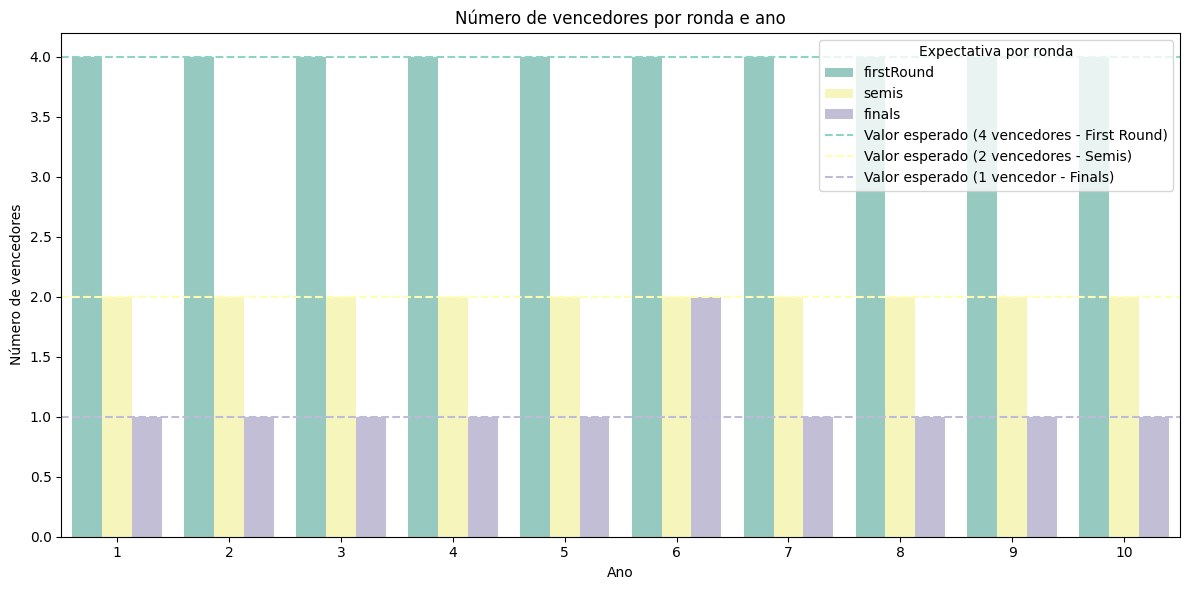

In [2464]:
teams = pd.read_csv('datasets/teams.csv')

# Transformar os dados de rodadas em formato longo
winner_counts = teams.melt(
    id_vars=['year', 'tmID'],  # Colunas fixas
    value_vars=['firstRound', 'semis', 'finals'],  # Colunas que serão transformadas
    var_name='round',  # Nome para a coluna das rodadas
    value_name='result'  # Nome para a coluna dos resultados
)

# Filtrar apenas as equipes vencedoras
winner_counts = winner_counts[winner_counts['result'] == 'W']

# Garantir a ordem correta das rodadas
round_order = ['firstRound', 'semis', 'finals']
winner_counts['round'] = pd.Categorical(winner_counts['round'], categories=round_order, ordered=True)

# Contar o número de vencedores por rodada e ano
winner_summary = winner_counts.groupby(['year', 'round']).size().reset_index(name='winner_count')

# Criar o gráfico
plt.figure(figsize=(12, 6))

# Cores para cada rodada
round_colors = {
    'firstRound': sns.color_palette('Set3')[0],
    'semis': sns.color_palette('Set3')[1],
    'finals': sns.color_palette('Set3')[2]
}

# Criar o gráfico de barras
sns.barplot(data=winner_summary, x='year', y='winner_count', hue='round', hue_order=round_order, palette=round_colors)

# Adicionar linhas de valor esperado da mesma cor das barras
plt.axhline(4, color=round_colors['firstRound'], linestyle='--', label='Valor esperado (4 vencedores - First Round)')
plt.axhline(2, color=round_colors['semis'], linestyle='--', label='Valor esperado (2 vencedores - Semis)')
plt.axhline(1, color=round_colors['finals'], linestyle='--', label='Valor esperado (1 vencedor - Finals)')

# Personalizar o gráfico
plt.title('Número de vencedores por ronda e ano')
plt.xlabel('Ano')
plt.ylabel('Número de vencedores')
plt.legend(title='Expectativa por ronda')
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [2465]:
# Calculate min, max, and average player count for each year

player_count_per_team_year = merged_df.groupby(['year', 'tmID'])['playerID'].nunique().reset_index()
player_count_per_team_year.columns = ['Year', 'Team', 'PlayerCount']

# print(player_count_per_team_year)

summary_stats = player_count_per_team_year.groupby('Year')['PlayerCount'].agg(['min', 'max', 'mean']).reset_index()
summary_stats.columns = ['Year', 'MinPlayerCount', 'MaxPlayerCount', 'AvgPlayerCount']

summary_stats.head(10)

,Year,MinPlayerCount,MaxPlayerCount,AvgPlayerCount
0,1,11,15,13.000000
1,2,11,18,13.000000
2,3,11,15,13.562500
3,4,11,21,12.857143
4,5,11,15,12.846154
5,6,12,16,13.692308
6,7,10,16,12.857143
7,8,10,15,13.307692
8,9,12,19,14.285714
9,10,9,18,12.692308


In [2466]:
# merge do awards com os coaches

awards_coaches_file = df3.rename(columns={'playerID': 'coachID'})
coach_awards = awards_coaches_file[awards_coaches_file['award'] == 'Coach of the Year']
coach_awards_grouped = coach_awards.groupby(['coachID', 'year'])['award'].apply(list).reset_index()
coaches_file = pd.merge(coaches_file, coach_awards_grouped, on=['coachID', 'year'], how='left')

In [2467]:
# Calculate average rebounds by position, excluding secondary positions
avg_rebounds_by_pos_filtered = (
    merged_df.groupby('pos')
    .agg(oRebounds=('oRebounds', 'mean'), dRebounds=('dRebounds', 'mean'))
    .reset_index()
    .query("pos in ['G', 'F', 'C']")
)

avg_rebounds_by_pos_filtered['d_over_o_reb'] = avg_rebounds_by_pos_filtered['dRebounds'] / avg_rebounds_by_pos_filtered['oRebounds']
avg_rebounds_by_pos_filtered.head(7)

,pos,oRebounds,dRebounds,d_over_o_reb
0,C,27.624031,59.895349,2.168233
2,F,30.177606,62.218147,2.061732
5,G,13.301973,38.188164,2.870865


In [2468]:
merged_df = merged_df.drop(columns=['rebounds', 'PostRebounds']) # resultado da célula anterior, os rebounds ofensivos/defensivos mudam de acordo com a posição da jogadora, logo decidimos tirar o total de rebounds
merged_df = merged_df.rename(columns={'GP_x': 'GP_player', 'GP_y': 'GP_team'}) # haviam duas colunas com nomes iguais, uma para as jogadoras e outra para as equipas, tinham ficado uma com x e a outra com y então demos rename

In [2469]:
# Criar Novas estatisticas -> PER (Player Effiency Rating)

grouped = merged_df.groupby('year').agg({
    'o_pts': 'sum',
    'o_fga': 'sum',
    'o_oreb': 'sum',
    'o_to': 'sum',
    'o_fta': 'sum',
    'o_asts': 'sum',
    'o_fgm' : 'sum',
    'o_ftm': 'sum',
    'o_dreb':'sum',
}).reset_index()

grouped['VOP'] = grouped['o_pts'] / (grouped['o_fga'] - grouped['o_oreb'] + grouped['o_to'] + 0.44 * grouped['o_fta'])
grouped['factor'] = (2 / 3) - (0.5 * (grouped['o_asts'] / grouped['o_fgm'])) / (2 * (grouped['o_fgm'] / grouped['o_ftm']))
grouped['DRB%'] = (grouped['o_dreb'] - grouped['o_oreb']) / grouped['o_dreb']

uPER_df = merged_df.groupby(['playerID', 'year']).agg({
    'minutes': 'sum',     
    'threeMade': 'sum',   
    'assists': 'sum',     
    'fgMade': 'sum',      
    'ftMade': 'sum',      
    'turnovers': 'sum',   
    'fgAttempted': 'sum', 
    'ftAttempted': 'sum', 
    'dRebounds': 'sum',   
    'oRebounds': 'sum',   
    'steals': 'sum',      
    'blocks': 'sum',      
    'PF': 'sum'           
}).reset_index()

uPER_df = uPER_df.merge(grouped[['year', 'VOP', 'factor', 'DRB%']], on='year')

uPER_df['TRB'] = uPER_df['dRebounds'] + uPER_df['oRebounds']

uPER_df['uPER'] = (1 / uPER_df['minutes']) * (
    uPER_df['threeMade'] +
    (2/3) * uPER_df['assists'] +
    (2 - uPER_df['factor'] * (uPER_df['assists'] / uPER_df['fgMade'])) * uPER_df['fgMade'] +
    (uPER_df['ftMade'] * 0.5 * (1 + (1 - (uPER_df['assists'] / uPER_df['fgMade'])) + (2/3) * (uPER_df['assists'] / uPER_df['fgMade']))) -
    uPER_df['VOP'] * uPER_df['turnovers'] -
    uPER_df['VOP'] * uPER_df['DRB%'] * (uPER_df['fgAttempted'] - uPER_df['fgMade']) -
    uPER_df['VOP'] * 0.44 * (0.44 + (0.56 * uPER_df['DRB%'])) * (uPER_df['ftAttempted'] - uPER_df['ftMade']) +
    uPER_df['VOP'] * (1 - uPER_df['DRB%']) * uPER_df['TRB'] +
    uPER_df['VOP'] * uPER_df['DRB%'] * uPER_df['oRebounds'] +
    uPER_df['VOP'] * uPER_df['steals'] +
    uPER_df['VOP'] * uPER_df['DRB%'] * uPER_df['blocks'] -
    uPER_df['PF'] * ((grouped['o_ftm'].mean() / grouped['o_pts'].mean()) - 0.44 * (grouped['o_fta'].mean() / grouped['o_pts'].mean()) * uPER_df['VOP'])
)

lg_uPER = uPER_df.groupby('year')['uPER'].mean().reset_index()
lg_uPER.rename(columns={'uPER': 'lg_uPER'}, inplace=True)

uPER_df = uPER_df.merge(lg_uPER, on='year')

uPER_df['PER'] = uPER_df['uPER'] * (15 / uPER_df['lg_uPER'])


In [2470]:
per_to_merge = uPER_df[['playerID', 'year', 'PER']]
merged_df = merged_df.merge(per_to_merge, on=['playerID', 'year'], how='left') # adicionar o PER ao dataset

# novas estatisticas
merged_df['TS%'] = (merged_df['points'] / (2 * (merged_df['fgAttempted'] + 0.44 * merged_df['ftAttempted'])))*100
merged_df['eFG%'] = ((merged_df['fgMade'] + 0.5 * merged_df['threeMade']) / merged_df['fgAttempted'])*100
merged_df['stocks'] = (merged_df['steals'] + merged_df['blocks'])
merged_df['dar'] = ((merged_df['steals'] + merged_df['blocks'] + merged_df['oRebounds'] + merged_df['dRebounds'])/merged_df['minutes'])

# substituir por 0 colunas vazias
merged_df['PER'] = merged_df['PER'].fillna(0)
merged_df['TS%'] = merged_df['TS%'].fillna(0)
merged_df['eFG%'] = merged_df['eFG%'].fillna(0)
merged_df['stocks'] = merged_df['stocks'].fillna(0)
merged_df['dar'] = merged_df['dar'].fillna(0)

#Equipas que não foram aos playoffs
merged_df['W'] = merged_df['W'].fillna(0)
merged_df['L'] = merged_df['L'].fillna(0)

In [2471]:
def box_plot_for_each_column(dataset):
    numeric_columns = dataset.select_dtypes(include='number')
    if numeric_columns.empty:
        print("No numeric columns found in the dataset.")
    else:
        numeric_columns.boxplot(figsize=(10, 6))
        plt.title("Boxplot for all numeric columns")
        plt.xticks(rotation=45)  # Rotation in x, if necessary
        plt.show()

def pearson_correlation(dataset, size_x, size_y):
    numeric_columns = dataset.select_dtypes(include='number')
    
    if numeric_columns.empty:
        print("Nenhuma coluna numérica encontrada no dataset.")
    else:
        # Correlation matrix
        correlation_matrix = numeric_columns.corr()

        # View
        plt.figure(figsize=(size_x, size_y))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Pearson-correlation')
        plt.show()

def bar_chart_for_each_column(dataset):
    non_numeric_columns = dataset.select_dtypes(exclude='number')
    if non_numeric_columns.empty:
        print("Any non-numeric columns found in the dataset.")
    else:
        for column in non_numeric_columns.columns:
            value_counts = non_numeric_columns[column].value_counts()
            plt.figure(figsize=(10, 6))
            value_counts.plot(kind='bar')
            plt.title(f"Bar chart for '{column}'")
            plt.xlabel(column)
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.tight_layout()  # Adjust layout to prevent overlap
            plt.show()

# Pie-chart for each column
def pie_chart_for_each_column(dataset):
    non_numeric_columns = dataset.select_dtypes(exclude='number')
    
    if non_numeric_columns.empty:
        print("Any non-numeric columns found in the dataset.")
    else:
        for column in non_numeric_columns.columns:
            # Count elements from different categories
            category_counts = dataset[column].value_counts()
            
            # Pie-chart
            plt.figure(figsize=(6, 6))
            category_counts.plot.pie(autopct='%1.1f%%', startangle=140)
            plt.title(f'Distribution of {column}')
            plt.ylabel('')  # Remove o rótulo do eixo Y
            plt.show()


#box_plot_for_each_column(merged_df)
#box_plot_for_each_column(coaches_file)
#box_plot_for_each_column(series_post_file)



In [2472]:
#pearson_correlation(merged_df, 100, 80)
#pearson_correlation(coaches_file, 8, 6)
#pearson_correlation(series_post_file, 8, 6)

In [2473]:
#bar_chart_for_each_column(merged_df)
#bar_chart_for_each_column(coaches_file)
#bar_chart_for_each_column(series_post_file)

In [2474]:
#pie_chart_for_each_column(merged_df)
#pie_chart_for_each_column(coaches_file)
#pie_chart_for_each_column(series_post_file)

In [2475]:
# Substituir valores nominais para valores relativos (one-attribute-per-value conversion)
def replaceGameResults(column):
    return column.apply(lambda value: '100' if value == 'W' else '010' if value == 'L' else '001')

# Aplicar a função para cada coluna específica
merged_df['firstRound'] = replaceGameResults(merged_df['firstRound'])
merged_df['semis'] = replaceGameResults(merged_df['semis'])
merged_df['finals'] = replaceGameResults(merged_df['finals'])


In [2476]:
# Guardar os datasets numa pasta
if not os.path.exists('cleanDatasets'):
    os.makedirs('cleanDatasets')

merged_df.to_csv('cleanDatasets/players_and_teams.csv', index=False)
coaches_file.to_csv('cleanDatasets/coaches_and_awards.csv', index=False)
series_post_file.to_csv('cleanDatasets/series_post.csv', index=False)

In [2477]:
# queriamos construir o dataset em relação às jogadoras então dropamos imensas colunas relativas à equipa

merged_df2 = merged_df.drop(columns=['minutes','threeMade','assists','fgMade','turnovers','fgAttempted','ftAttempted','oRebounds','steals','blocks','PF','o_ftm','o_pts','o_fta','o_pts','o_fga','o_oreb','o_to','o_asts','o_fgm','o_dreb']) # estes atributos já se encontram nas novas colunas criadas
merged_df2 = merged_df2.drop(columns=['GP_player','GS','ftMade','threeAttempted','GP_team'])
merged_df2 = merged_df2.drop(columns=['o_3pm','o_3pa','o_reb','o_pf','o_stl','o_blk','d_fgm','d_fga','d_ftm','d_fta','d_3pm','d_3pa','d_oreb','d_dreb','d_reb','d_asts','d_pf','d_stl','d_to','d_blk','d_pts'])
merged_df2 = merged_df2.drop(columns=['PostGP','PostGS','PostMinutes','PostPoints','PostoRebounds','PostdRebounds','PostAssists','PostSteals','PostBlocks','PostTurnovers','PostPF','PostfgAttempted','PostfgMade','PostftAttempted','PostftMade','PostthreeAttempted','PostthreeMade','PostDQ'])
merged_df2 = merged_df2.drop(columns=['arena'])

# substituir BirthDate por ano em que nasceram
merged_df2['birthDate'] = pd.to_datetime(merged_df['birthDate'], errors='coerce').dt.year
merged_df2 = merged_df2.rename(columns={'birthDate': 'birthYear'})

if not os.path.exists('cleanDatasets'):
    os.makedirs('cleanDatasets')

merged_df2.to_csv('cleanDatasets/advancedstatistics.csv', index=False)

In [2478]:
#Juntar os treinadores


# Agrupar coaches por year e team, transformando em listas
coaches_grouped = df6.groupby(['year', 'tmID'])['coachID'].apply(list).reset_index()

# Fazer o merge com o ficheiro
merged_df2 = merged_df2.merge(coaches_grouped, on=['year', 'tmID'], how='left')

merged_df2.head(5)

,playerID,year,stint,tmID,points,dRebounds,dq,pos,height,weight,...,min,attend,W,L,PER,TS%,eFG%,stocks,dar,coachID
0,abrossv01w,2,0,MIN,343,131,2,F,74.0,169,...,6475,120607,0.0,0.0,19.293262,48.849265,42.150171,51,0.265957,[aglerbr99w]
1,abrossv01w,3,0,MIN,314,101,0,F,74.0,169,...,6475,139874,0.0,0.0,15.898093,42.774629,40.822785,52,0.245963,"[aglerbr99w, vandehe99w]"
2,abrossv01w,4,0,MIN,318,97,0,F,74.0,169,...,6850,120253,1.0,2.0,18.485960,48.457881,43.684211,55,0.247475,[mcconsu01w]
3,abrossv01w,5,0,MIN,146,57,0,F,74.0,169,...,6850,125097,0.0,2.0,14.545585,45.842753,42.446043,32,0.229437,[mcconsu01w]
4,abrossv01w,6,0,MIN,304,78,0,F,74.0,169,...,6850,113447,0.0,0.0,18.086335,49.331429,45.471014,54,0.207207,[mcconsu01w]


In [2479]:
players_stats_prevYear = merged_df2[['playerID','year','PER', 'eFG%', 'TS%','stocks','dRebounds','dar']].drop_duplicates().copy() #TODO Acrescentar aqui mais variaveis

#players_stats_prevYear['legacy_points'] = merged_df2['points']
players_stats_prevYear['legacy_points'] = merged_df2['won']
players_stats_prevYear['year'] = players_stats_prevYear['year'] + 1


players_stats_prevYear = players_stats_prevYear.merge(
    merged_df2[['playerID', 'year', 'tmID', 'playoff','coachID']], 
    on=['playerID', 'year'], 
    how='left')

players_stats_prevYear.to_csv('cleanDatasets/players_stats_prevYear.csv', index=False)

In [2480]:
#.............................Fazer a media por equipa dos valores mas pegando apenas nos 7 melhores jogadores...............

# Ordenar os jogadores dentro de cada equipe e ano com base no PER (ou outra métrica)
players_stats_prevYear_sorted = players_stats_prevYear.sort_values(by=['tmID', 'year', 'PER'], ascending=[True, True, False])

# Selecionar os 5 melhores jogadores de cada equipe e ano
top_7_players = players_stats_prevYear_sorted.groupby(['tmID', 'year']).head(5)

# Agora, calcular a média das métricas apenas para os melhores jogadores
team_year_stats = top_7_players.groupby(['tmID', 'year', 'playoff']).agg({
    'PER': 'mean',
    'TS%': 'mean',
    'eFG%': 'mean',
    'stocks': 'mean',
    'dRebounds': 'mean',
    'dar': 'mean',
    'coachID': 'first',  # Seleciona o primeiro valor da coluna (presumindo que todos sejam iguais para o grupo)
    'legacy_points' : 'mean' #Same here
}).reset_index()

# Salva o novo dataset em um arquivo CSV
team_year_stats.to_csv('cleanDatasets/team_year_stats.csv', index=False)

team_year_stats.head(5)

,tmID,year,playoff,PER,TS%,eFG%,stocks,dRebounds,dar,coachID,legacy_points
0,ATL,9,0.0,19.894077,53.647675,50.207877,26.6,57.2,0.238431,[meadoma99w],18.8
1,ATL,10,1.0,21.751629,55.257063,51.579845,49.6,88.2,0.315709,[meadoma99w],10.8
2,CHA,2,1.0,20.571617,53.362027,47.843485,29.0,52.6,0.217976,[donovan99w],16.0
3,CHA,3,1.0,19.356376,52.945163,47.204217,36.4,73.2,0.236983,[donovan99w],18.0
4,CHA,4,1.0,20.989740,53.544432,46.980211,37.6,75.2,0.213686,[laceytr99w],18.0


In [2481]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

#Para depois poder ir buscar as variavies categoricas
team_year_stats_copy = team_year_stats.copy()


# Selecionar as colunas de interesse
features = team_year_stats[['PER', 'TS%', 'eFG%','stocks','dRebounds']] #TODO Acrescentar aqui tambem

# Normalizar os dados usando MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Aplicar o PCA
pca = PCA(n_components=3) #TODO mudar aqui o numero de colunas a selecionar
pca.fit(features_scaled)

# Verificar as cargas (coeficientes) dos componentes principais
components = pca.components_

# Baseado nas cargas, você pode decidir as variáveis mais importantes
# Vamos mostrar a importância de cada variável nas componentes principais

# Calcular a soma das cargas absolutas para cada variável
importance = pd.DataFrame(abs(components), columns=['PER', 'TS%', 'eFG%','stocks','dRebounds'], index=['PC1', 'PC2','PC3']) #TODO mudar aqui as variaveis
#TODO meter tantos PC quanto variaves a selecionar
importance_sum = importance.sum(axis=0)

# Selecionar as duas variáveis mais importantes
most_important_features = importance_sum.sort_values(ascending=False).head(3) #TODO mudar aqui o numero de variaveis

# Exibir apenas os nomes das variáveis mais importantes
important_variable_names = most_important_features.index.tolist()

# Inicializar a lista de componentes a serem removidos
components_to_drop = ['PER', 'TS%', 'eFG%','stocks','dRebounds','dar'] #TODO mudar aqui as variavies (TODOS OS ATRIBUTOS AQUI)
#TODO nao esquecer de aqui adicionar as nao numericas, como os coaches

# Remover as variáveis mais importantes da lista de componentes a serem removidos
components_to_drop = [col for col in components_to_drop if col not in important_variable_names]

team_year_stats=team_year_stats.drop(columns=components_to_drop)

#Adicionar as variaveis categoricas, como os coaches, que nao passaram no processo de PCA
team_year_stats['coachID'] = team_year_stats_copy['coachID']
#team_year_stats['legacy_points'] = team_year_stats_copy['legacy_points']
#important_variable_names.append('legacy_points')

# Exibir o resultado
print(team_year_stats)

    tmID  year  playoff        PER       eFG%  stocks  \
0    ATL     9      0.0  19.894077  50.207877    26.6   
1    ATL    10      1.0  21.751629  51.579845    49.6   
2    CHA     2      1.0  20.571617  47.843485    29.0   
3    CHA     3      1.0  19.356376  47.204217    36.4   
4    CHA     4      1.0  20.989740  46.980211    37.6   
..   ...   ...      ...        ...        ...     ...   
121  WAS     6      0.0  17.387332  46.823234    46.8   
122  WAS     7      1.0  20.574946  51.330317    39.4   
123  WAS     8      0.0  21.686321  55.716693    47.8   
124  WAS     9      0.0  21.568455  45.065012    47.0   
125  WAS    10      1.0  19.989199  51.201160    32.2   

                      coachID  legacy_points  
0                [meadoma99w]           18.8  
1                [meadoma99w]           10.8  
2                [donovan99w]           16.0  
3                [donovan99w]           18.0  
4                [laceytr99w]           18.0  
..                        ...    

In [2482]:
# Normalizar os dados 

# Selecionar apenas colunas numéricas
# Lista de colunas a normalizar
columns_to_normalize = ['PER', 'eFG%', 'stocks','legacy_points'] #TODO baseado nas colunas selecionadas do dataset de cima

# Aplicar a normalização apenas nas colunas selecionadas
team_year_stats[columns_to_normalize] = team_year_stats[columns_to_normalize].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Verificar o resultado
print(team_year_stats.head())


  tmID  year  playoff       PER      eFG%    stocks       coachID  \
0  ATL     9      0.0  0.424361  0.642733  0.182965  [meadoma99w]   
1  ATL    10      1.0  0.569981  0.695814  0.545741  [meadoma99w]   
2  CHA     2      1.0  0.477476  0.551256  0.220820  [donovan99w]   
3  CHA     3      1.0  0.382209  0.526523  0.337539  [donovan99w]   
4  CHA     4      1.0  0.510254  0.517857  0.356467  [laceytr99w]   

   legacy_points  
0       0.609524  
1       0.228571  
2       0.476190  
3       0.571429  
4       0.571429  


In [2483]:
""" #Passar as colunas que nao sao numericas para numericas
# One-Hot Encoding e é útil para transformar colunas categóricas em representações numéricas binárias.

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# Codificando a lista de coaches em colunas binárias
coach_dummies = mlb.fit_transform(team_year_stats['coachID'])

# Adicionando as novas colunas no dataframe original
coach_columns = mlb.classes_
team_year_stats = team_year_stats.join(pd.DataFrame(coach_dummies, columns=coach_columns))

# Adicionando os nomes das novas colunas à lista de variáveis importantes
important_variable_names.extend(coach_columns) """

" #Passar as colunas que nao sao numericas para numericas\n# One-Hot Encoding e é útil para transformar colunas categóricas em representações numéricas binárias.\n\nfrom sklearn.preprocessing import MultiLabelBinarizer\n\nmlb = MultiLabelBinarizer()\n\n# Codificando a lista de coaches em colunas binárias\ncoach_dummies = mlb.fit_transform(team_year_stats['coachID'])\n\n# Adicionando as novas colunas no dataframe original\ncoach_columns = mlb.classes_\nteam_year_stats = team_year_stats.join(pd.DataFrame(coach_dummies, columns=coach_columns))\n\n# Adicionando os nomes das novas colunas à lista de variáveis importantes\nimportant_variable_names.extend(coach_columns) "

In [2484]:
#Dividir o dataset para treino, validacao e teste 

dataset_treino = team_year_stats[(team_year_stats['year'] >= 6) & (team_year_stats['year'] <= 9)]
dataset_teste = team_year_stats[team_year_stats['year'] == 10]

In [2485]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgb

# Features (X) e alvo (y)
X_treino = dataset_treino[important_variable_names] #Antigamente 'PER', 'TS%', 'eFG%'
y_treino = dataset_treino['playoff']

X_teste = dataset_teste[important_variable_names]
y_teste = dataset_teste['playoff']


In [2486]:
#Criar ficheiros para guardar resultados e avaliar
dataset_resultados = pd.DataFrame({})

dataset_resultados["playoff"] = dataset_teste["playoff"]

In [2487]:
# Inicializar o modelo de regressão linear
modelo = RandomForestRegressor()

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["RandomForestRegressor"] = y_pred_teste

/tmp/ipykernel_136628/597684550.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2488]:
# Inicializar o modelo de regressão linear
modelo = GradientBoostingRegressor()

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["GradientBoostingRegressor"] = y_pred_teste

/tmp/ipykernel_136628/450214780.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2489]:
# Inicializar o modelo de regressão linear
modelo = LinearRegression()

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["LinearRegression"] = y_pred_teste

/tmp/ipykernel_136628/3123343135.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2490]:
#::::::::::::::::::::Este modelo é uma variante da regressão linear que usa regularização L2 para reduzir overfitting.::::::::::::::::

# Inicializar o modelo de Ridge Regression
modelo = Ridge(alpha=1.0)  # alpha controla o nível de regularização

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["Ridge"] = y_pred_teste


/tmp/ipykernel_136628/1713031855.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2491]:
# Similar ao Ridge, mas utiliza regularização L1. Tende a eliminar variáveis menos importantes, útil para seleção de features.
# Inicializar o modelo de Lasso Regression
modelo = Lasso(alpha=0.1, random_state=42)  # alpha controla a força da regularização

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

/tmp/ipykernel_136628/977365062.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2492]:
# Combina as regularizações L1 (Lasso) e L2 (Ridge).
# Inicializar o modelo de Elastic Net
modelo = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
# `alpha` controla a força total da regularização.
# `l1_ratio` controla a proporção de regularização L1 (Lasso) em relação à L2 (Ridge).

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

/tmp/ipykernel_136628/151494901.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2493]:
# Inicializar o modelo de MLP
modelo = MLPRegressor(hidden_layer_sizes=(100, 50),  # Camadas ocultas com 100 e 50 neurônios
                      activation='relu',            # Função de ativação
                      solver='adam',                # Otimizador
                      max_iter=500,                 # Número máximo de iterações
                      random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["MLPRegressor_relu"] = y_pred_teste


/tmp/ipykernel_136628/1530820846.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2494]:
# Inicializar o modelo de MLP
modelo = MLPRegressor(hidden_layer_sizes=(100, 50),  # Camadas ocultas com 100 e 50 neurônios
                      activation='tanh',            # Função de ativação
                      solver='adam',                # Otimizador
                      max_iter=500,                 # Número máximo de iterações
                      random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["MLPRegressor_tanh"] = y_pred_teste

/tmp/ipykernel_136628/3422886681.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2495]:
# Inicializar o modelo de MLP
modelo = MLPRegressor(hidden_layer_sizes=(100, 50),  # Camadas ocultas com 100 e 50 neurônios
                      activation='logistic',            # Função de ativação
                      solver='adam',                # Otimizador
                      max_iter=500,                 # Número máximo de iterações
                      random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

#Adicioanar a coluna aos resultados
dataset_resultados["MLPRegressor_logistic"] = y_pred_teste

/tmp/ipykernel_136628/989847951.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2496]:
import numpy as np

# Inicializar o modelo sequencial
modelo = Sequential()

# Adicionar camadas
modelo.add(Dense(64, activation='relu', input_shape=(X_treino.shape[1],)))  # Primeira camada oculta
modelo.add(Dense(32, activation='relu'))  # Segunda camada oculta
modelo.add(Dense(1))  # Camada de saída (regressão)

# Compilar o modelo
modelo.compile(optimizer='adam', loss='mse')

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste).flatten()  # Flatten para transformar em 1D

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["Sequential_relu"] = y_pred_teste

Epoch 1/50


/home/emamartins12/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.3965 - val_loss: 0.4067
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3596 - val_loss: 0.3614
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3297 - val_loss: 0.3213
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2880 - val_loss: 0.2881
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2675 - val_loss: 0.2610
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2453 - val_loss: 0.2416
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2241 - val_loss: 0.2276
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2205 - val_loss: 0.2181
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2072 - val_loss: 0.2130
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2115 - val_loss: 0.2108
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2153 - val_loss: 0.2102
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2063 - val_loss: 0.2099
Epoch 13/50

/tmp/ipykernel_136628/2146543663.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2497]:
import numpy as np

# Inicializar o modelo sequencial
modelo = Sequential()

# Adicionar camadas
modelo.add(Dense(64, activation='tanh', input_shape=(X_treino.shape[1],)))  # Primeira camada oculta
modelo.add(Dense(32, activation='tanh'))  # Segunda camada oculta
modelo.add(Dense(1))  # Camada de saída (regressão)

# Compilar o modelo
modelo.compile(optimizer='adam', loss='mse')

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste).flatten()  # Flatten para transformar em 1D

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["Sequential_tanh"] = y_pred_teste

Epoch 1/50


/home/emamartins12/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.8575 - val_loss: 0.7234
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6201 - val_loss: 0.5406
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4809 - val_loss: 0.4007
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3576 - val_loss: 0.3028
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2663 - val_loss: 0.2420
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2239 - val_loss: 0.2125
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2098 - val_loss: 0.2060
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2218 - val_loss: 0.2114
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2201 - val_loss: 0.2193
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2293 - val_loss: 0.2214
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2465 - val_loss: 0.2177
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2488 - val_loss: 0.2121
Epoch 13/50

/tmp/ipykernel_136628/2325067666.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2498]:
# Inicializar o modelo de regressão com Extra Trees
modelo = ExtraTreesRegressor(random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["ExtraTreesRegressor"] = y_pred_teste

/tmp/ipykernel_136628/4200620747.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2499]:
# Inicializar o modelo ElasticNet
modelo = ElasticNet(random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["ElasticNet"] = y_pred_teste


/tmp/ipykernel_136628/2178884686.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2500]:
# Inicializar o modelo XGBoost Regressor
modelo = xgb.XGBRegressor(random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["XGBRegressor"] = y_pred_teste


/tmp/ipykernel_136628/4215414685.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2501]:
# Inicializar o modelo LightGBM Regressor
modelo = lgb.LGBMRegressor(random_state=42)

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

dataset_resultados["LGBMRegressor"] = y_pred_teste



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56
[LightGBM] [Info] Number of data points in the train set: 54, number of used features: 3
[LightGBM] [Info] Start training from score 0.592593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/tmp/ipykernel_136628/191379248.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste


In [2502]:
# Inicializar o modelo de regressão com Gradient Boosting
modelo = GradientBoostingRegressor(random_state=42) #TODO porque foi o melhor modelo até agora

# Treinar o modelo com os dados de treino
modelo.fit(X_treino, y_treino)

# Fazer previsões no conjunto de teste
y_pred_teste = modelo.predict(X_teste)

# Adicionar a coluna prevista ao dataset_teste
dataset_teste['playoff_previsto'] = y_pred_teste

# Critério de correção
# 1. Quando 'playoff' é 1, 'playoff_previsto' deve ser > 0.5
# 2. Quando 'playoff' é 0, 'playoff_previsto' deve ser <= 0.5

# Criar uma coluna indicando se a previsão está correta
dataset_teste['correto'] = ((dataset_teste['playoff'] == 1) & (dataset_teste['playoff_previsto'] > 0.5)) | \
                           ((dataset_teste['playoff'] == 0) & (dataset_teste['playoff_previsto'] <= 0.5))

# Contar o número de previsões corretas
corretos = dataset_teste['correto'].sum()

# Número total de exemplos
total = len(dataset_teste)

# Exibir o resultado
print(f"Previsões corretas: {corretos} de {total} ({(corretos / total) * 100:.2f}%)")

dataset_resultados["GradientBoostingRegressor"] = y_pred_teste


Previsões corretas: 11 de 13 (84.62%)


/tmp/ipykernel_136628/2616487240.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['playoff_previsto'] = y_pred_teste
/tmp/ipykernel_136628/2616487240.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_teste['correto'] = ((dataset_teste['playoff'] == 1) & (dataset_teste['playoff_previsto'] > 0.5)) | \


In [2503]:
#Para mostrar os resultados obtidos pelos varios modelos
dataset_resultados.head(20)

,playoff,RandomForestRegressor,GradientBoostingRegressor,LinearRegression,Ridge,MLPRegressor_relu,MLPRegressor_tanh,MLPRegressor_logistic,Sequential_relu,Sequential_tanh,ExtraTreesRegressor,ElasticNet,XGBRegressor,LGBMRegressor
1,1.0,0.95,1.045405,0.728279,0.697980,0.713013,0.715274,0.681498,0.707385,0.649079,0.85,0.592593,0.999276,0.851383
11,0.0,0.89,0.361693,0.803413,0.698456,0.778541,0.778881,0.682181,0.710258,0.721816,0.78,0.592593,0.892613,0.617658
21,0.0,0.25,0.448585,0.454783,0.551575,0.497108,0.509502,0.681200,0.553418,0.469095,0.34,0.592593,0.544007,0.645756
30,1.0,0.65,0.789038,0.408074,0.513340,0.459743,0.508846,0.681679,0.539205,0.472283,0.82,0.592593,0.630869,0.509037
47,1.0,0.78,0.629658,0.849808,0.736482,0.814483,0.817354,0.682105,0.750421,0.748930,0.50,0.592593,0.930184,0.507009
56,1.0,0.98,0.831841,1.364818,1.059298,1.124377,1.294917,0.683387,1.109771,1.139512,1.00,0.592593,0.981451,0.714665
67,0.0,0.95,0.709914,1.049900,0.868357,0.946538,1.038851,0.682835,0.906649,0.931011,1.00,0.592593,0.998547,0.714665
76,0.0,0.62,0.497143,0.482872,0.556478,0.509492,0.494340,0.680994,0.548395,0.461398,0.74,0.592593,0.382291,0.438101
87,1.0,0.83,0.902431,0.680021,0.692969,0.670628,0.710793,0.681503,0.705906,0.636452,0.90,0.592593,0.741859,0.846527
98,0.0,0.39,0.626527,0.472492,0.540668,0.502142,0.488840,0.681139,0.535397,0.460921,0.42,0.592593,0.351148,0.438101


In [2504]:
# Resultados considerando que 0.5 para cima é 1 e 0.5 para baixo da 0
from sklearn.metrics import precision_score, recall_score, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# Criando o DataFrame
df = pd.DataFrame(dataset_resultados)

# Inicializar lista para armazenar os resultados
resultados = []

# Loop sobre cada coluna do modelo (excluindo a coluna 'playoff')
for modelo in df.columns[1:]:
    # Cálculo de métricas de regressão
    mse = mean_squared_error(df["playoff"], df[modelo])
    mae = mean_absolute_error(df["playoff"], df[modelo])
    r2 = abs(r2_score(df["playoff"], df[modelo]))
    
    # Binarização dos valores (0.5 como limite)
    y_true = (df["playoff"] >= 0.5).astype(int)
    y_pred = (df[modelo] >= 0.5).astype(int)
    
    # Cálculo de métricas de classificação
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Adicionar os resultados à lista
    resultados.append({
        "Modelo": modelo,
        "MSE": mse,
        "MAE": mae,
        "R²": r2,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy
    })

# Converter os resultados em um DataFrame
resultados_cima_baixo = pd.DataFrame(resultados)

# Exibir os resultados
resultados_cima_baixo.head(10)


,Modelo,MSE,MAE,R²,Precision,Recall,Accuracy
0,RandomForestRegressor,0.241546,0.405385,0.020532,0.700000,0.875,0.692308
1,GradientBoostingRegressor,0.154425,0.343021,0.347554,0.800000,1.000,0.846154
2,LinearRegression,0.301208,0.499405,0.272603,0.714286,0.625,0.615385
3,Ridge,0.253184,0.462794,0.069704,0.583333,0.875,0.538462
4,MLPRegressor_relu,0.270535,0.472854,0.143010,0.600000,0.750,0.538462
5,MLPRegressor_tanh,0.292519,0.493855,0.235892,0.666667,0.750,0.615385
6,MLPRegressor_logistic,0.241081,0.458076,0.018566,0.615385,1.000,0.615385
7,Sequential_relu,0.259170,0.467833,0.094991,0.583333,0.875,0.538462
8,Sequential_tanh,0.273756,0.485220,0.156619,0.714286,0.625,0.615385
9,ExtraTreesRegressor,0.254508,0.421538,0.075295,0.727273,1.000,0.769231


In [2505]:
# Resultados considerando que ficam a 1 os 8 melhores

from sklearn.metrics import precision_score, recall_score, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

# Criando o DataFrame
df = pd.DataFrame(dataset_resultados)

# Inicializar lista para armazenar os resultados
resultados = []

# Número de melhores previsões para considerar como 1
top_n = 8

# Loop sobre cada coluna do modelo (excluindo a coluna 'playoff')
for modelo in df.columns[1:]:
    # Cálculo de métricas de regressão
    mse = mean_squared_error(df["playoff"], df[modelo])
    mae = mean_absolute_error(df["playoff"], df[modelo])
    r2 = abs(r2_score(df["playoff"], df[modelo]))
    
    # Binarização dos valores (top 8 melhores como 1)
    y_true = (df["playoff"] >= 0.5).astype(int)
    y_pred = pd.Series(0, index=df.index)  # Inicializa com 0 para todos
    top_indices = df[modelo].nlargest(top_n).index  # Obtém índices dos top 8 valores
    y_pred.loc[top_indices] = 1  # Define 1 para os top 8 valores
    
    # Cálculo de métricas de classificação
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Adicionar os resultados à lista
    resultados.append({
        "Modelo": modelo,
        "MSE": mse,
        "MAE": mae,
        "R²": r2,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy
    })

# Converter os resultados em um DataFrame
resultados_8_melhores = pd.DataFrame(resultados)

# Exibir os resultados
resultados_8_melhores.head(10)


,Modelo,MSE,MAE,R²,Precision,Recall,Accuracy
0,RandomForestRegressor,0.241546,0.405385,0.020532,0.750,0.750,0.692308
1,GradientBoostingRegressor,0.154425,0.343021,0.347554,0.875,0.875,0.846154
2,LinearRegression,0.301208,0.499405,0.272603,0.750,0.750,0.692308
3,Ridge,0.253184,0.462794,0.069704,0.625,0.625,0.538462
4,MLPRegressor_relu,0.270535,0.472854,0.143010,0.750,0.750,0.692308
5,MLPRegressor_tanh,0.292519,0.493855,0.235892,0.625,0.625,0.538462
6,MLPRegressor_logistic,0.241081,0.458076,0.018566,0.750,0.750,0.692308
7,Sequential_relu,0.259170,0.467833,0.094991,0.625,0.625,0.538462
8,Sequential_tanh,0.273756,0.485220,0.156619,0.750,0.750,0.692308
9,ExtraTreesRegressor,0.254508,0.421538,0.075295,0.625,0.625,0.538462


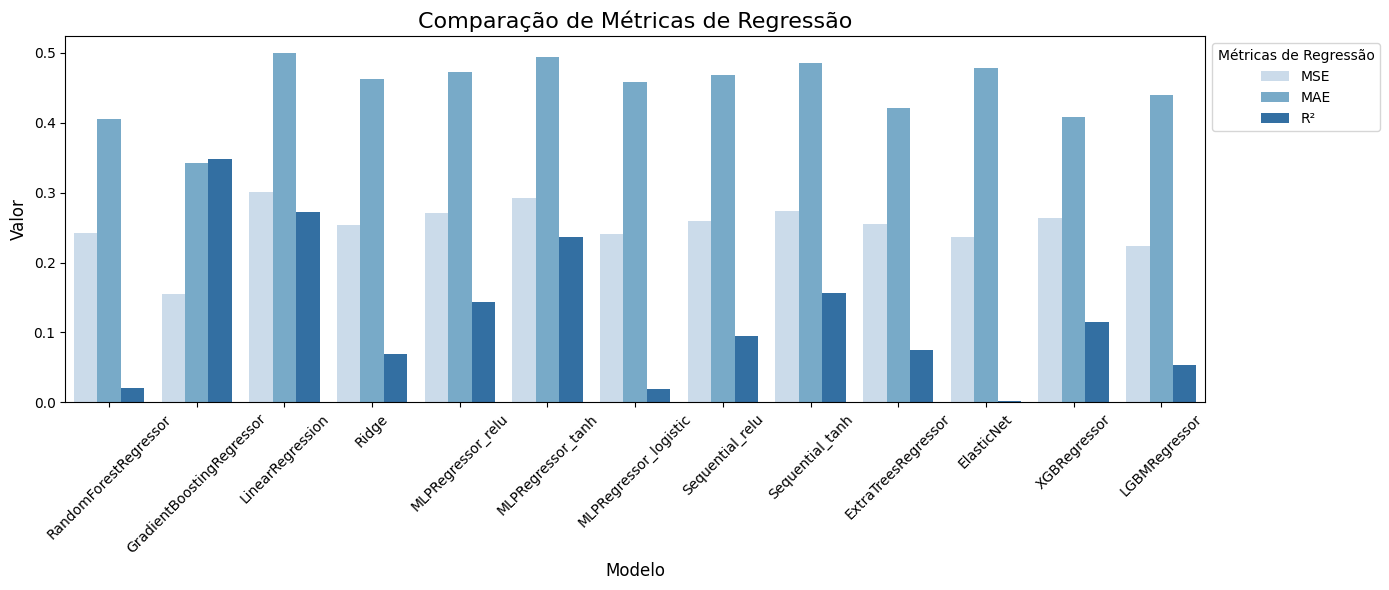

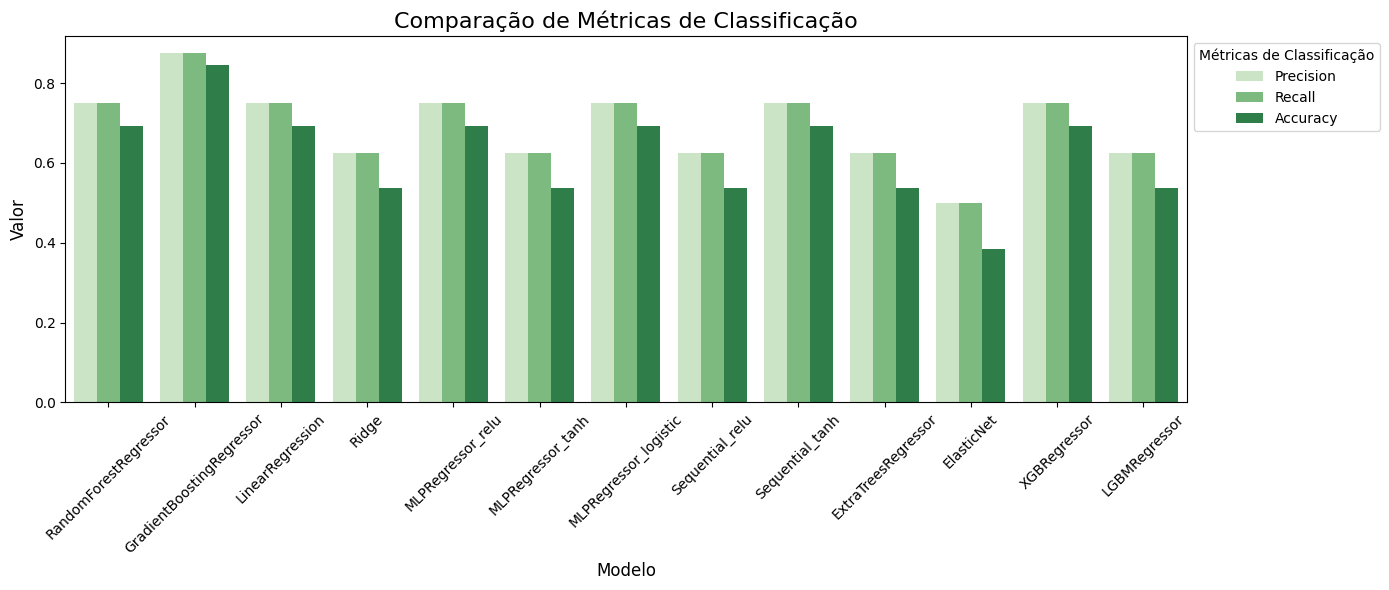

In [ ]:
#Condiredando os 8 melhores 1 e o resto 0

regression_metrics = ['MSE', 'MAE', 'R²']
classification_metrics = ['Precision', 'Recall', 'Accuracy']

# Transformar o DataFrame em formato longo
resultados_regression = resultados_8_melhores.melt(
    id_vars='Modelo', 
    value_vars=regression_metrics, 
    var_name='Métrica', 
    value_name='Valor'
)

resultados_classification = resultados_8_melhores.melt(
    id_vars='Modelo', 
    value_vars=classification_metrics, 
    var_name='Métrica', 
    value_name='Valor'
)

# Gráfico de métricas de regressão
plt.figure(figsize=(14, 6))
sns.barplot(data=resultados_regression, x='Modelo', y='Valor', hue='Métrica', palette='Blues')
plt.title('Comparação de Métricas de Regressão', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Métricas de Regressão', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Gráfico de métricas de classificação
plt.figure(figsize=(14, 6))
sns.barplot(data=resultados_classification, x='Modelo', y='Valor', hue='Métrica', palette='Greens')
plt.title('Comparação de Métricas de Classificação', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Métricas de Classificação', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

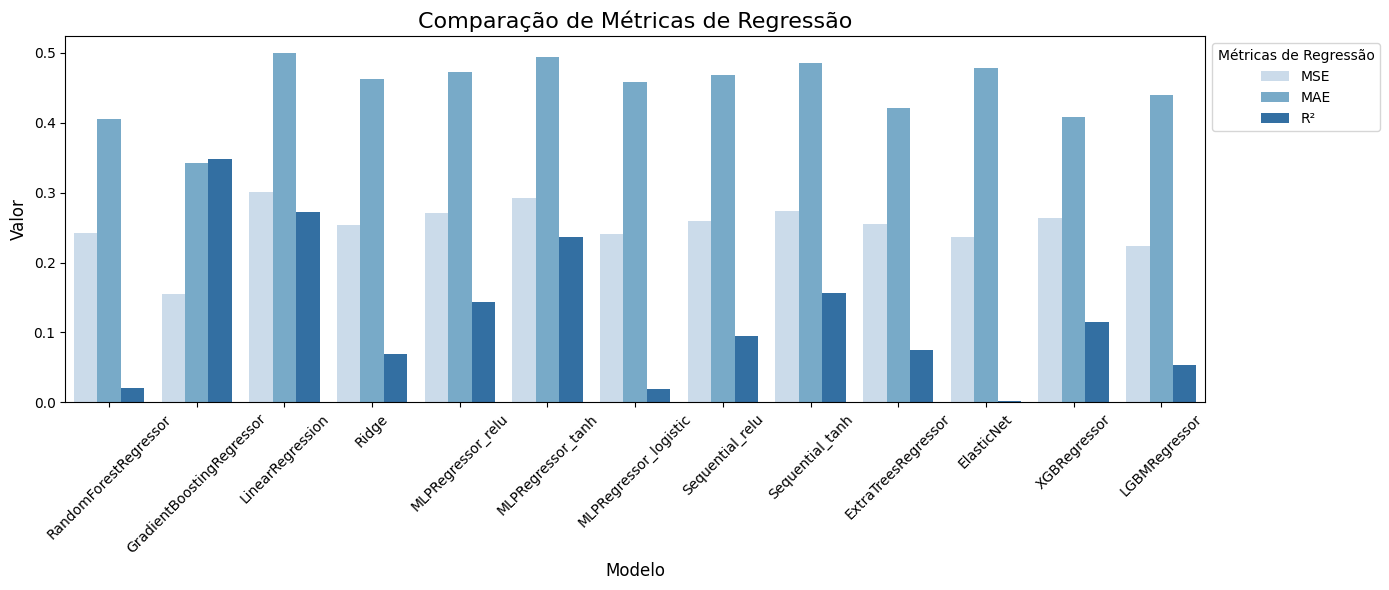

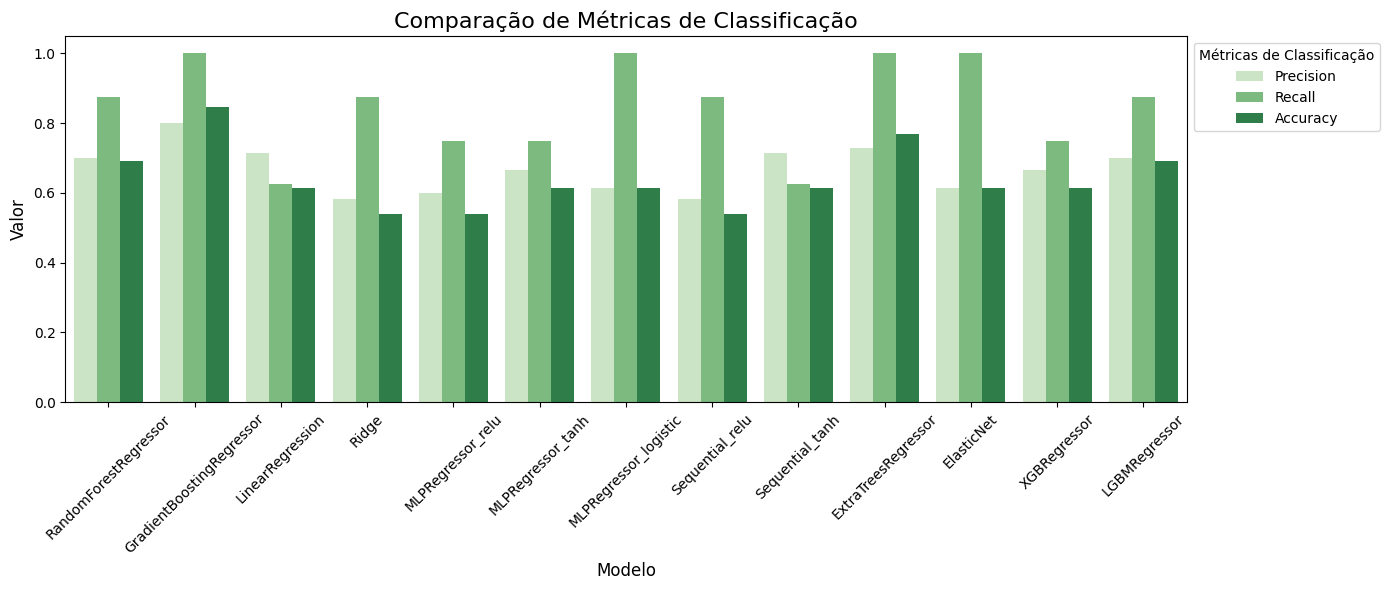

In [ ]:
#Condiredando os 0.5 para cima 1, se nao 0
regression_metrics = ['MSE', 'MAE', 'R²']
classification_metrics = ['Precision', 'Recall', 'Accuracy']

# Transformar o DataFrame em formato longo
resultados_regression = resultados_cima_baixo.melt(
    id_vars='Modelo', 
    value_vars=regression_metrics, 
    var_name='Métrica', 
    value_name='Valor'
)

resultados_classification = resultados_cima_baixo.melt(
    id_vars='Modelo', 
    value_vars=classification_metrics, 
    var_name='Métrica', 
    value_name='Valor'
)

# Gráfico de métricas de regressão
plt.figure(figsize=(14, 6))
sns.barplot(data=resultados_regression, x='Modelo', y='Valor', hue='Métrica', palette='Blues')
plt.title('Comparação de Métricas de Regressão', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Métricas de Regressão', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Gráfico de métricas de classificação
plt.figure(figsize=(14, 6))
sns.barplot(data=resultados_classification, x='Modelo', y='Valor', hue='Métrica', palette='Greens')
plt.title('Comparação de Métricas de Classificação', fontsize=16)
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Métricas de Classificação', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()